In [ ]:
from google.colab import files
files.upload()

Saving train_2_pr.csv to train_2_pr.csv
Saving test_2.csv to test_2.csv


{'test_2.csv': b',shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected\n0,S002736,2019-10-04 14:27:04,A,Y,GB,IN,86.81,100.0,0.75,Air,SC3,Y\n1,S002738,2020-01-07 09:39:35,A,Y,GB,IN,94.43,1006.0,0.75,Air,SC3,Y\n2,S005739,2020-04-11 11:58:10,A,Y,GB,IN,93.55,321.0,1.05,Air,SC2,Y\n3,S008722,2019-06-23 11:54:41,A,Y,GB,IN,88.74,355.0,1.05,Air,SC2,Y\n4,S009737,2019-11-20 20:18:01,A,Y,GB,IN,92.83,115.0,1.05,Air,SC2,Y\n5,S010737,2019-11-20 20:30:05,A,Y,GB,IN,92.48,115.0,0.75,Air,SC3,Y\n6,S010739,2020-04-11 14:49:27,A,Y,GB,IN,94.23,325.0,1.05,Air,SC2,Y\n7,S011739,2020-04-11 14:53:25,A,Y,GB,IN,94.45,325.0,0.75,Air,SC3,Y\n8,S013702,2019-02-14 05:32:35,A,Y,GB,IN,90.9403,1506.0,0.9,Ocean,SC1,Y\n9,S013737,2019-11-21 09:44:06,A,Y,GB,IN,92.92,115.0,1.05,Air,SC2,Y\n10,S014702,2019-02-14 05:54:43,A,Y,GB,IN,90.9403,15.7,0.9,Ocean,SC1,Y\n11,S014708,2019-03-23 06:39:22,A,Y,GB,IN,90.39,61.0

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train=pd.read_csv('train_2_pr.csv')
test=pd.read_csv('test_2.csv')

In [ ]:
df.head()

,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,selected,shipping_time,send_timestamp_year,send_timestamp_day,send_timestamp_weekofyear,send_timestamp_month,send_timestamp_dayofweek,send_timestamp_weekend,send_timestamp_hour,send_timestamp_minute,shipment_charges_0.5625,shipment_charges_0.75,shipment_charges_0.9,shipment_charges_1.05,shipment_charges_1.125,shipment_mode_Air,shipment_mode_Ocean,shipping_company_SC1,shipping_company_SC2,shipping_company_SC3
0,S000720,2019-06-08 07:17:51,0,1,0,1,88.61,355.0,0,5.00741,2019,8,23,6,5,1,7,17,0,1,0,0,0,1,0,0,0,1
1,S000725,2019-07-12 15:23:21,0,1,0,1,85.65,105.0,0,21.41215,2019,12,28,7,4,0,15,23,0,0,1,0,0,0,1,1,0,0
2,S000736,2019-10-04 14:23:29,0,1,0,1,86.22,100.0,0,5.33692,2019,4,40,10,4,0,14,23,0,1,0,0,0,1,0,0,0,1
3,S000738,2020-01-07 09:19:50,0,1,0,1,94.43,1071.0,0,5.14792,2020,7,2,1,1,0,9,19,0,0,0,1,0,1,0,0,1,0
4,S000739,2020-04-11 06:36:03,0,1,0,1,94.24,2007.0,0,5.03067,2020,11,15,4,5,1,6,36,0,1,0,0,0,1,0,0,0,1


In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
df.nunique(),df.isnull().sum(), df.shape

(shipment_id                  5897
 send_timestamp               5896
 pick_up_point                   1
 drop_off_point                  2
 source_country                  1
 destination_country             2
 freight_cost                 2304
 gross_weight                 1463
 shipment_charges                5
 shipment_mode                   2
 shipping_company                3
 selected                        1
 shipping_time                4315
 send_timestamp_year             2
 send_timestamp_day             31
 send_timestamp_weekofyear      51
 send_timestamp_month           12
 send_timestamp_dayofweek        7
 send_timestamp_weekend          2
 send_timestamp_hour            24
 send_timestamp_minute          60
 dtype: int64, shipment_id                     0
 send_timestamp                  0
 pick_up_point                   0
 drop_off_point                  0
 source_country                  0
 destination_country             0
 freight_cost                    0
 gross

In [ ]:
del df['Unnamed: 0']

In [ ]:
k=['send_timestamp']
for i in k:
  df[i] = pd.to_datetime(df[i])
for i in k:
  df[i+'_'+'year'] = df[i].dt.year
  df[i+'_'+'day'] = df[i].dt.day
  df[i+'_'+'weekofyear'] = df[i].dt.weekofyear
  df[i+'_'+'month'] = df[i].dt.month
  df[i+'_'+'dayofweek'] =df[i].dt.dayofweek
  df[i+'_'+'weekend'] = (df[i].dt.weekday >=5).astype(int)
  df[i+'_'+'hour'] = df[i].dt.hour
  df[i+'_'+'minute'] = df[i].dt.minute
del df['send_timestamp']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [ ]:
df = pd.get_dummies(df, columns=['shipment_charges','shipment_mode','shipping_company'])

In [ ]:
x=['pick_up_point','drop_off_point','source_country','destination_country','selected']
from sklearn.preprocessing import LabelEncoder
for i in x:
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])

In [ ]:
train = df[df['shipping_time'].isnull()==False]
test = df[df['shipping_time'].isnull()==True]
del test['shipping_time']

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
train_df['shipping_time'] = np.log1p(train_df['shipping_time'])
del train_df['shipment_id']
del test_df['shipment_id']
del train_df['send_timestamp']
del test_df['send_timestamp'] 

In [ ]:
X = train_df.drop(labels=['shipping_time'], axis=1)
y = train_df['shipping_time'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((3835, 25), (3835,), (1279, 25), (1279,))

In [ ]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error

# lgb

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 1000,
         'num_leaves': 69,
         'max_depth': -1,
         'min_data_in_leaf': 12,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 250
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.expm1(y_cv), np.expm1(y_pred_lgbm))))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.338747
[200]	valid_0's rmse: 0.348763
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.32882
RMSLE: 0.32882012987273707


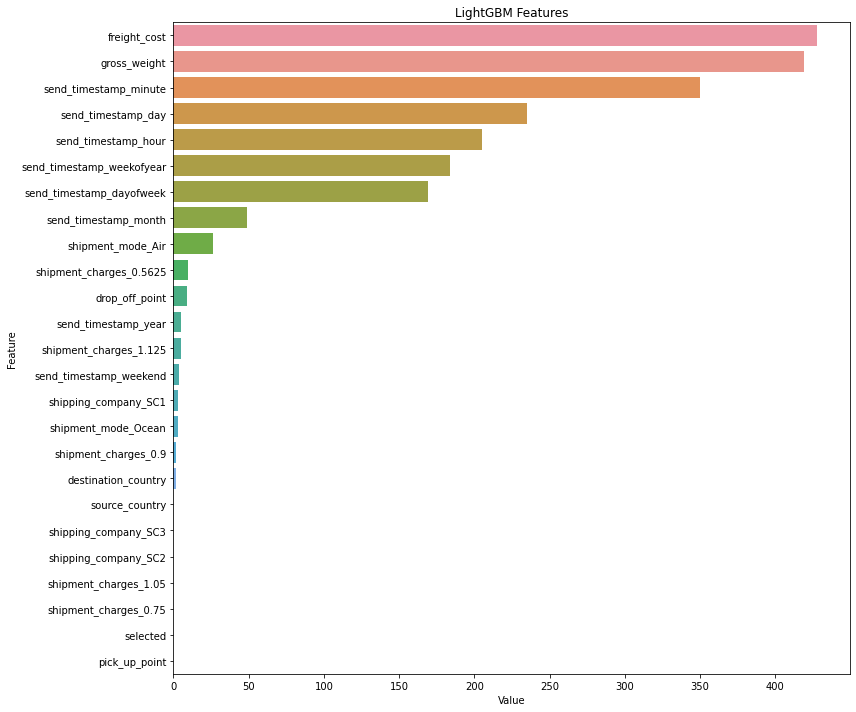

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:

from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=4, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.3105207919217344


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.30705335115237087


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.3216123592765874


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.3146714741165501


In [ ]:
np.mean(errlgb,0)

0.3134644941168107

In [ ]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))
lgbm_final

array([ 5.0170116,  5.3336487,  5.1354876, ..., 11.378776 ,  9.08507  ,
       14.983445 ], dtype=float32)

In [ ]:
submission = pd.DataFrame({
        "x":lgbm_final
    })
submission.to_csv('./bit0.csv', index=False)
print(submission)

              x
0      5.017012
1      5.333649
2      5.135488
3      5.244751
4      5.211668
...         ...
1255  13.700871
1256  16.507214
1257  11.378776
1258   9.085070
1259  14.983445

[1260 rows x 1 columns]


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

errxgb = []
y_pred_totxgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #xgb = XGBRegressor(random_state=101)
    xgb=XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', max_depth=9, n_estimators=1000)#tree_method='gpu_hist')# )
    xgb.fit(X_train, y_train)

    y_pred_xgb = xgb.predict(X_test)
    print("RMSLE: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_xgb))))

    errxgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_xgb))))
    p = xgb.predict(Xtest)

    y_pred_totxgb.append(p)

RMSLE:  0.3469935141512315
RMSLE:  0.3357918737821158
RMSLE:  0.34683334680050126
RMSLE:  0.3519372376109644
RMSLE:  0.335023588846955
RMSLE:  0.32272625326006166
RMSLE:  0.3467748831642464
RMSLE:  0.3513953705669006
RMSLE:  0.32572922691121203
RMSLE:  0.34022560701922555
